In [1]:
import json
from datasets import load_dataset, Dataset, load_from_disk
from transformers import AutoTokenizer
from tqdm import tqdm
import numpy as np

In [2]:
CACHE_DIR = "/huggingface/cache"

TOKENIZER_NAME = "./dart-tokenizer-20240219"

DATASET_NAME = "isek-ai/danbooru-tags-2023"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    TOKENIZER_NAME, trust_remote_code=True, cache_dir=CACHE_DIR
)

In [4]:
ds = load_dataset(DATASET_NAME, name="all", split="train", cache_dir=CACHE_DIR)
ds

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 6574149
})

## Simple filtering


In [5]:
ds = ds.filter(lambda x: x["general"] is not None, batched=False)
ds

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 6574005
})

## Remove not popular tags


In [6]:
def load_tags(path: str):
    with open(path, "r", encoding="utf-8") as file:
        tags_txt = file.read()
    tags = tags_txt.split("\n")
    return tags


general_general = load_tags("./popular-tags/general-general.txt")
general_sensitive = load_tags("./popular-tags/general-sensitive.txt")
general_questionable = load_tags("./popular-tags/general-questionable.txt")
general_explicit = load_tags("./popular-tags/general-explicit.txt")

character_tags = load_tags("./popular-tags/character.txt")
copyright_tags = load_tags("./popular-tags/copyright.txt")

all_general_tags = (
    general_general + general_sensitive + general_questionable + general_explicit
)

In [8]:
ds

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 6574005
})

In [9]:
def not_have_unpopular_tags(examples):
    flags = [True for _ in examples["id"]]

    # for i, general in enumerate(examples["general"]):
    #     new_tags = []
    #     for tag in general.split(", "):
    #         if tag in all_general_tags:
    #             new_tags.append(tag)
    #     examples["general"][i] = ", ".join(new_tags)

    for i, copyright in enumerate(examples["copyright"]):
        if copyright is None:
            continue

        for tag in copyright.split(", "):
            if tag not in copyright_tags:
                flags[i] = False

    for i, character in enumerate(examples["character"]):
        if character is None:
            continue

        if flags[i]:
            for tag in character.split(", "):
                if tag not in character_tags:
                    flags[i] = False
                    continue

    return flags


ds = ds.filter(not_have_unpopular_tags, batched=True)
ds

Filter:   0%|          | 0/6574005 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 5312968
})

## Remove bad tags


In [10]:
from tag_manager import TagManger

In [11]:
tag_manager = TagManger()

In [12]:
def remove_bad_tags(examples):
    for i, general in enumerate(examples["general"]):
        new_tags = []
        for tag in general.split(", "):
            if not tag_manager.should_remove(tag):
                new_tags.append(tag)
        examples["general"][i] = ", ".join(new_tags)

    return examples


ds = ds.map(remove_bad_tags, batched=True)
ds

Map:   0%|          | 0/5312968 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 5312968
})

## Inspect tag counts


In [13]:
import matplotlib.pyplot as plt

In [14]:
general_tags_counts = []

ds.map(
    lambda x: general_tags_counts.append(len(x["general"].split(", "))), batched=False
)

Map:   0%|          | 0/5312968 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 5312968
})

In [15]:
max(general_tags_counts)

479

In [16]:
min(general_tags_counts)

1

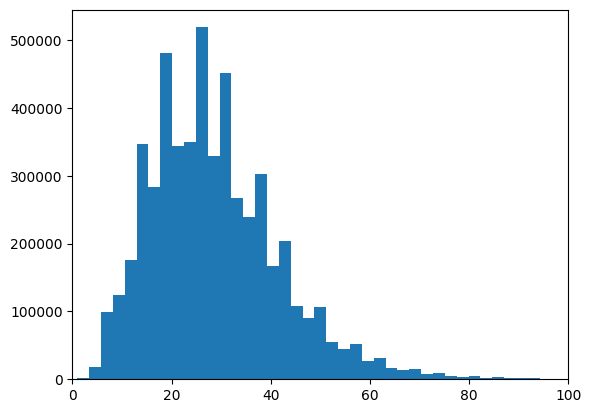

In [17]:
plt.hist(general_tags_counts, bins=200)
plt.xlim([0, 100])
plt.show()

In [18]:
copyright_tags_counts = []

ds.map(
    lambda x: copyright_tags_counts.append(
        len(x["copyright"].split(", ")) if x["copyright"] is not None else 0
    ),
    batched=False,
)

Map:   0%|          | 0/5312968 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 5312968
})

In [19]:
max(copyright_tags_counts)

51

In [20]:
import numpy as np

In [21]:
np.average(copyright_tags_counts)

1.3197037889179832

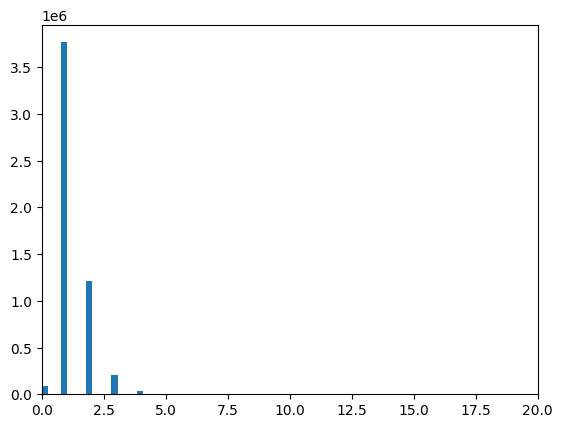

In [22]:
plt.hist(copyright_tags_counts, bins=200)
plt.xlim([0, 20])
plt.show()

In [23]:
character_tags_counts = []

ds.map(
    lambda x: character_tags_counts.append(
        len(x["character"].split(", ")) if x["character"] is not None else 0
    ),
    batched=False,
)

Map:   0%|          | 0/5312968 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 5312968
})

In [24]:
max(character_tags_counts)

179

In [25]:
np.average(character_tags_counts)

1.3975932096711292

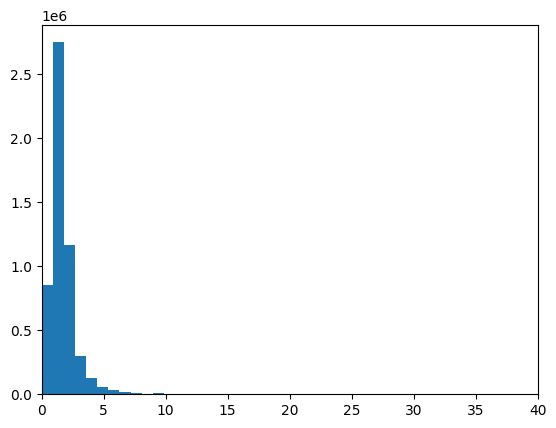

In [26]:
plt.hist(character_tags_counts, bins=200)
plt.xlim([0, 40])
plt.show()

## Filter tags by counts


In [27]:
# remove
# general > 100
# copyright > 5
# character > 10

ds = ds.filter(lambda x: len(x["general"].split(", ")) <= 100, batched=False)
ds

Filter:   0%|          | 0/5312968 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 5307251
})

In [28]:
ds = ds.filter(
    lambda x: (
        len(x["copyright"].split(", ")) <= 5 if x["copyright"] is not None else True
    ),
    batched=False,
)
ds

Filter:   0%|          | 0/5307251 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 5302522
})

In [29]:
ds = ds.filter(
    lambda x: (
        len(x["character"].split(", ")) <= 10 if x["character"] is not None else True
    ),
    batched=False,
)
ds

Filter:   0%|          | 0/5302522 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 5293004
})

## Save filtered tags


In [30]:
ds.save_to_disk("danbooru-tags-filtered-20240219")

Saving the dataset (0/6 shards):   0%|          | 0/5293004 [00:00<?, ? examples/s]

## Concat tags


In [ ]:
ds = load_from_disk("./danbooru-tags-filtered-20240219")

In [31]:
rating_map = {
    "g": "rating:general",
    "s": "rating:sensitive",
    "q": "rating:questionable",
    "e": "rating:questionable",
}

rating_parent_tag_map = {
    "g": "rating:sfw",
    "s": "rating:sfw",
    "q": "rating:nsfw",
    "e": "rating:nsfw",
}

In [32]:
assert all(
    [
        tokenizer.convert_tokens_to_ids(token) != tokenizer.unk_token
        for token in list(rating_map.values()) + list(rating_parent_tag_map.values())
    ]
)

In [33]:
BOS = "<|bos|>"
EOS = "<|eos|>"

RATING_BOS = "<rating>"
RATING_EOS = "</rating>"

COPYRIGHT_BOS = "<copyright>"
COPYRIGHT_EOS = "</copyright>"

CHARACTER_BOS = "<character>"
CHARACTER_EOS = "</character>"

GENERAL_BOS = "<general>"
GENERAL_EOS = "</general>"

In [34]:
assert all(
    [
        tokenizer.convert_tokens_to_ids(token) != tokenizer.unk_token
        for token in [
            BOS,
            EOS,
            RATING_BOS,
            RATING_EOS,
            COPYRIGHT_BOS,
            COPYRIGHT_EOS,
            CHARACTER_BOS,
            CHARACTER_EOS,
            GENERAL_BOS,
            GENERAL_EOS,
        ]
    ]
)

In [35]:
ds

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 5293004
})

In [36]:
def concat_tags(examples):
    all_tags = []

    for i, _ in enumerate(examples["id"]):
        rating = examples["rating"][i]
        copyright = examples["copyright"][i]
        character = examples["character"][i]
        general = examples["general"][i]

        assert rating is not None
        assert general is not None

        rating, rating_parent = rating_map[rating], rating_parent_tag_map[rating]

        if copyright is None:
            copyright = ""
        if character is None:
            character = ""

        tag_text = "".join(
            [
                BOS,
                RATING_BOS,
                rating_parent,
                ", ",
                rating,
                RATING_EOS,
                COPYRIGHT_BOS,
                copyright,
                COPYRIGHT_EOS,
                CHARACTER_BOS,
                character,
                CHARACTER_EOS,
                GENERAL_BOS,
                general,
                GENERAL_EOS,
                EOS,
            ]
        )
        all_tags.append(tag_text)

    return {"tag_text": all_tags}


ds = ds.map(concat_tags, batched=True)
ds

Map:   0%|          | 0/5293004 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at', 'tag_text'],
    num_rows: 5293004
})

In [37]:
ds["tag_text"][:5]

['<|bos|><rating>rating:nsfw, rating:questionable</rating><copyright></copyright><character></character><general>1boy, 1girl, :|, ;d, age difference, bat wings, bath, bathing, bathroom, bathtub, black eyes, black hair, blue eyes, bored, censored, cheek squash, closed mouth, collarbone, completely nude, cowboy shot, demon girl, demon tail, dutch angle, female pubic hair, flat chest, frottage, happy, hetero, horns, indoors, loli, looking at another, looking at viewer, mini wings, mixed-sex bathing, mosaic censoring, naughty face, navel, nipples, nude, one eye closed, open mouth, outstretched arm, pink hair, pointy ears, pubic hair, pussy, shared bathing, short hair, smile, soap bubbles, sparse pubic hair, steam, sweatdrop, tail, two side up, wet, wings</general><|eos|>',
 '<|bos|><rating>rating:nsfw, rating:questionable</rating><copyright>slayers</copyright><character>lina inverse, naga the serpent</character><general>2girls, 69, ass, back, blue eyes, blush, breasts, circlet, closed eyes

In [38]:
ds.save_to_disk("./danbooru-tagtext-20240219")

Saving the dataset (0/11 shards):   0%|          | 0/5293004 [00:00<?, ? examples/s]

## Tokenize


In [4]:
ds = load_from_disk("./danbooru-tagtext-20240219")
ds

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at', 'tag_text'],
    num_rows: 6524302
})

In [39]:
tokenizer(
    "<|bos|><rating>rating:nsfw, rating:questionable</rating><copyright>dragon quest, dragon quest v</copyright><character>hero's daughter (dq5), king slime, slime (dragon quest)</character><general>1girl, :d, ^_^, ass, bestiality, black eyes, blob, blonde hair, blue skin, blush, boots, bow, closed eyes, clothes lift, colored skin, crown, dress, dress lift, female orgasm, full body, gloves, hair bow, hat, head back, loli, no panties, open mouth, orgasm, rape, see-through, see-through body, short dress, simple background, sketch, smile, solo, tears, top-down bottom-up, vaginal, wince</general><|eos|>",
)

{'input_ids': [0, 4, 49, 46, 5, 6, 3252, 931, 7, 8, 12129, 3, 14631, 9, 10, 60268, 61285, 38967, 39211, 47069, 50914, 58886, 55184, 42984, 32162, 55932, 45343, 25530, 28649, 59997, 24239, 66120, 51088, 46454, 18581, 19188, 65308, 65393, 27019, 67294, 53925, 31442, 21535, 67510, 29954, 32664, 49077, 40333, 45530, 43500, 40044, 32039, 32815, 67386, 36057, 11, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [40]:
column_names = ds.column_names
column_names.remove("tag_text")
column_names

['id',
 'copyright',
 'character',
 'artist',
 'general',
 'meta',
 'rating',
 'score',
 'created_at']

In [42]:
def tokenize_text(examples):
    tokenized = tokenizer(examples["tag_text"])
    input_ids = tokenized.input_ids

    # check not to have unknown copyright or character tags
    for i, token_ids in enumerate(input_ids):
        unk_token_idx = [
            i for i, x in enumerate(token_ids) if x == tokenizer.unk_token_id
        ]
        general_bos_idx = token_ids.index(10)

        if any([unk < general_bos_idx for unk in unk_token_idx]):
            raise Exception("unk before general!")

    input_ids = [  # remove unk token
        [token_id for token_id in item if token_id != tokenizer.unk_token_id]
        for item in input_ids
    ]

    return {**tokenized}


ds = ds.map(tokenize_text, batched=True, remove_columns=column_names)
ds

Map:   0%|          | 0/5293004 [00:00<?, ? examples/s]

Dataset({
    features: ['tag_text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5293004
})

In [43]:
ds[1000]

{'tag_text': '<|bos|><rating>rating:sfw, rating:sensitive</rating><copyright>to heart (series), to heart 2</copyright><character>himeyuri ruri, himeyuri sango, ilfa (to heart)</character><general>3girls, animal ears, bun cover, buruma, cat ears, cat tail, comic, double bun, greyscale, gym uniform, hair bun, monochrome, mouse ears, mouse tail, multiple girls, tail, thighhighs</general><|eos|>',
 'input_ids': [0,
  4,
  48,
  45,
  5,
  6,
  499,
  2647,
  7,
  8,
  15158,
  7845,
  4179,
  9,
  10,
  47498,
  24847,
  23653,
  63183,
  34279,
  29591,
  46121,
  36792,
  43736,
  31133,
  33982,
  56065,
  17149,
  30195,
  18572,
  45564,
  19477,
  11,
  1],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


In [44]:
ds.save_to_disk("./danbooru-tokenized-20240219")

Saving the dataset (0/9 shards):   0%|          | 0/5293004 [00:00<?, ? examples/s]

### push to hub


In [ ]:
ds = load_from_disk("./danbooru-tokenized-20240219")
ds

In [45]:
ds.push_to_hub("p1atdev/dart-tokenized-pretrain-20240219")

Uploading the dataset shards:   0%|          | 0/9 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/589 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/589 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/589 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/589 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/589 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/589 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/589 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/589 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/589 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/p1atdev/dart-tokenized-pretrain-20240219/commit/013e3afc021ce12f418ba510be15cc56716caa85', commit_message='Upload dataset', commit_description='', oid='013e3afc021ce12f418ba510be15cc56716caa85', pr_url=None, pr_revision=None, pr_num=None)